In [14]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from tqdm.notebook import tqdm, trange
sns.set_theme(style="ticks")

df = sns.load_dataset("penguins")
# sns.pairplot(df, hue="species")

In [15]:
df = df.dropna()

In [16]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_df = df.select_dtypes(include=numerics)

In [17]:
num_df.to_json

<bound method NDFrame.to_json of      bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0              39.1           18.7              181.0       3750.0
1              39.5           17.4              186.0       3800.0
2              40.3           18.0              195.0       3250.0
4              36.7           19.3              193.0       3450.0
5              39.3           20.6              190.0       3650.0
..              ...            ...                ...          ...
338            47.2           13.7              214.0       4925.0
340            46.8           14.3              215.0       4850.0
341            50.4           15.7              222.0       5750.0
342            45.2           14.8              212.0       5200.0
343            49.9           16.1              213.0       5400.0

[333 rows x 4 columns]>

In [18]:
scatter = df[['bill_length_mm', 'bill_depth_mm']]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bill_depth_mm', ylabel='bill_length_mm'>

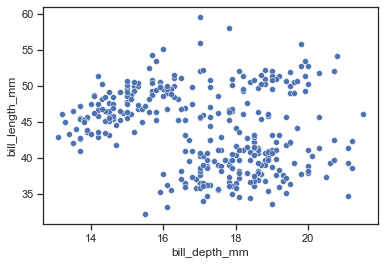

In [19]:
sns.scatterplot(scatter['bill_depth_mm'], scatter['bill_length_mm'])

In [14]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

def get_best_cluster_labels(cur_pts):
    data = scatter.iloc[cur_pts]
    scores_2d = -1
    scores_x = -1
    scores_y = -1
    labels_2d, labels_x, labels_y = [0], [0], [0]
    best_2d, best_x, best_y = 0,0,0
    for n_clusters in [2,3,4,5,6]:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        try:
            cur_labels_2d = clusterer.fit_predict(data)
            cur_labels_x = clusterer.fit_predict(np.array(data['bill_depth_mm']).reshape(-1,1))
            cur_labels_y = clusterer.fit_predict(np.array(data['bill_length_mm']).reshape(-1,1))
            cur_score_2d = silhouette_score(data, cur_labels_2d)
            cur_score_x = silhouette_score(np.array(data['bill_depth_mm']).reshape(-1,1), 
                                           cur_labels_x)
            cur_score_y = silhouette_score(np.array(data['bill_length_mm']).reshape(-1,1), 
                                       cur_labels_y)
        except ValueError:
            cur_score_2d = -1
            cur_score_x = -1
            cur_score_y = -1

        if cur_score_2d > scores_2d:
            scores_2d = cur_score_2d
            labels_2d = cur_labels_2d
            best_2d = n_clusters
        if cur_score_x > scores_x:
            scores_x = cur_score_x
            labels_x = cur_labels_x
            best_x = n_clusters
        if cur_score_y > scores_y:
            scores_y = cur_score_y
            labels_y = cur_labels_y
            best_y = n_clusters
    return labels_2d, labels_x, labels_y, best_2d, best_x, best_y

Important points
- All the properties are independent of each other
- Each point can have multiple properties

Algorithm initial steps
- Make the clusters very small for effective functioning of the detectors

PCP marginal clusters

- All the points are in same clusters (neighborhood)
    - Set Difference is zero
- Density of a cluster changes in the other axis (density change)
- Points split up into multiple clusters (Split up)
    - Default every point is marked split up
- Small cluster in one axis become many different clusters on the other axis with higher density (Fan)
- Evenly spread in both axis (Clutter)

PCP scatterplot clusters
- Outlier detection
- correlation
- variance
- skewness
- clear grouping

In [15]:
def neighborhood(cl_1, cl_2):
    if set(cl_1) - set(cl_2) == set():
        return True
    return False

In [7]:
window_size = 2

In [8]:
x_pts = np.linspace(scatter.bill_length_mm.min(), scatter.bill_length_mm.max(), 10)
y_pts = np.linspace(scatter.bill_depth_mm.min(), scatter.bill_depth_mm.max(), 10)

In [9]:
x_range = scatter.bill_length_mm.max() - scatter.bill_length_mm.min()
y_range = scatter.bill_depth_mm.max() - scatter.bill_depth_mm.min()

In [10]:
# Varying window size option, currently we are using fixed window size
# x_windows = np.linspace(x_range/10, x_range, 6)
# y_windows = np.linspace(y_range/10, y_range, 6)

In [11]:
x_windows = [window_size]
y_windows = [window_size]

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
scatter['labels_2d'] = 0
scatter['labels_x'] = 0
scatter['labels_y'] = 0
scatter['correlation'] = 0
scatter['variance'] = 0
scatter['skewness'] = 0
scatter['neigh'] = False
scatter['split_up'] = False
scatter['fan'] = False

## Creating json for the table

In [36]:
matrix = scatter[['bill_length_mm', 'bill_depth_mm']]

In [40]:
matrix.to_json(orient='records')

'[{"bill_length_mm":39.1,"bill_depth_mm":18.7},{"bill_length_mm":39.5,"bill_depth_mm":17.4},{"bill_length_mm":40.3,"bill_depth_mm":18.0},{"bill_length_mm":36.7,"bill_depth_mm":19.3},{"bill_length_mm":39.3,"bill_depth_mm":20.6},{"bill_length_mm":38.9,"bill_depth_mm":17.8},{"bill_length_mm":39.2,"bill_depth_mm":19.6},{"bill_length_mm":41.1,"bill_depth_mm":17.6},{"bill_length_mm":38.6,"bill_depth_mm":21.2},{"bill_length_mm":34.6,"bill_depth_mm":21.1},{"bill_length_mm":36.6,"bill_depth_mm":17.8},{"bill_length_mm":38.7,"bill_depth_mm":19.0},{"bill_length_mm":42.5,"bill_depth_mm":20.7},{"bill_length_mm":34.4,"bill_depth_mm":18.4},{"bill_length_mm":46.0,"bill_depth_mm":21.5},{"bill_length_mm":37.8,"bill_depth_mm":18.3},{"bill_length_mm":37.7,"bill_depth_mm":18.7},{"bill_length_mm":35.9,"bill_depth_mm":19.2},{"bill_length_mm":38.2,"bill_depth_mm":18.1},{"bill_length_mm":38.8,"bill_depth_mm":17.2},{"bill_length_mm":35.3,"bill_depth_mm":18.9},{"bill_length_mm":40.6,"bill_depth_mm":18.6},{"bill_l

## Code for single sliding window

In [14]:
import sys
correlation = []
variance = []
skewness = []
for x in range(len(x_pts)):
    cur_pts = np.where((scatter.bill_length_mm >= x_pts[x]) & 
                (scatter.bill_length_mm <= x_pts[x]+window_size))

    if len(cur_pts[0]) > 0:
        data = scatter.iloc[cur_pts]
        matrix = data[['bill_length_mm', 'bill_depth_mm']]
        correlation.append([x_pts[x], matrix.corr()['bill_length_mm']['bill_depth_mm']])
        variance.append([x_pts[x], np.cov(matrix.T)[0,1]])
        skewness.append([x_pts[x], scipy.stats.skew(matrix)[0]])

### Dasgupta Code

In [49]:
from itertools import combinations
def getCrossingData(dimensions):
    # dimensions = ['bill_length_mm', 'bill_depth_mm']
    crossings = 0
    crossing_data = []
    data_points = []
    for pair in combinations(scatter.index, 2):
        if ((scatter.loc[pair[0]][dimensions[0]] < scatter.loc[pair[1]][dimensions[0]] and 
             scatter.loc[pair[0]][dimensions[1]] > scatter.loc[pair[1]][dimensions[1]]) or 
            (scatter.loc[pair[0]][dimensions[0]] > scatter.loc[pair[1]][dimensions[0]] and 
             scatter.loc[pair[0]][dimensions[1]] < scatter.loc[pair[1]][dimensions[1]])):
                crossings += 1
                crossing_data.append(pair);
    return crossing_data

In [ ]:
crossing_data = getCrossingData(dimensions)

In [59]:
# Get Crossing Angles between two dimensions
import math, statistics
def getCrossingAngles(crossing_data, dimensions):
    # dimensions = ['bill_length_mm', 'bill_depth_mm']
    # crossing_data = getCrossingData(dimensions)
    crossing_angles = []
    if len(crossing_data) != 0:
        for pt1, pt2 in crossing_data:
            data_a = scatter.loc[pt1]
            data_b = scatter.loc[pt2]
            slope_a = 0
            slope_b = 0
            if data_a[dimensions[0]] != data_a[dimensions[1]]:
                slope_a = data_a[dimensions[1]] - data_a[dimensions[0]] 
            if data_b[dimensions[0]] != data_b[dimensions[1]]:
                slope_b = data_b[dimensions[1]] - data_b[dimensions[0]]

            tan = math.atan((slope_a - slope_b) / (1+slope_a*slope_b))/math.pi*180
            crossing_angles.append(min(tan, 90-tan))
    return statistics.median(crossing_angles)

In [83]:
# Parallelism 
from scipy import stats
from sklearn.preprocessing import minmax_scale
def getParallelism(dimensions):
    para = []
    for id in scatter.index:
        para.append(scatter.loc[id][dimensions[1]] - scatter.loc[id][dimensions[0]])
    para = minmax_scale(para)
    return 1-stats.iqr(para)

In [86]:
# 1D histogram
import numpy as np
dim1_hist = np.histogram(scatter.bill_length_mm, bins=256)

In [88]:
dim2_hist = np.histogram(scatter.bill_depth_mm, bins=256)

In [89]:
# 2d histograms

In [126]:
bi_hist, xed, yed = np.histogram2d(scatter.bill_length_mm, scatter.bill_depth_mm, bins=256)

In [133]:
# Get bin indices given a range
xst = 34
window = 4

257

In [134]:
xbin_ids = np.where(np.logical_and(xed>=xst, xed<=xst+window))

In [106]:
# Overplotting
overplot = (bi_hist > 1).sum()

In [110]:
unique_vals, counts = np.unique(bi_hist, return_counts=True)

In [111]:
overplot = 0
for i in range(2,len(unique_vals)):
    overplot += counts[i]*unique_vals[i]

In [113]:
overplot_norm = 2*overplot/(len(scatter.bill_length_mm)*len(scatter.bill_length_mm)-1)

In [114]:
overplot_norm

0.00014428973378544116

In [115]:
# Convergence (Lower the better)

In [139]:
cur_data = bi_hist[xbin_ids,:]

In [121]:
bi_hist.max()

2.0

In [142]:
convergence = (cur_data > 0).sum()

In [143]:
convergence

52

## Code for double sliding window
- Window x slides
- Window y slides
- Calculate 2D and marginal properties on these two sliding windows simultaneously

In [ ]:
import sys
results = {}
for x in tqdm(range(len(x_pts))):
    for y in range(len(y_pts)):
        for wx in x_windows:
            for wy in y_windows:
                # Choosing the points in that grid
                cur_pts = np.where((scatter.bill_length_mm >= x_pts[x]) & 
                            (scatter.bill_length_mm <= x_pts[x]+wx) &
                            (scatter.bill_depth_mm >= y_pts[y]) &
                            (scatter.bill_depth_mm <= y_pts[y]+wy)
                           )
                
                if len(cur_pts[0]) > 0:
                    # For current grid, get the best labels for 2d and marginal clusters
                    labels_2d, labels_x, labels_y, best_2d, best_x, best_y = get_best_cluster_labels(cur_pts)
                    correlation, variance, skewness = 0,0,0
                    neigh, split_up, fan = False, False, False
                    # Assign 2d and marginal ids to each point in the current sliding window
                    for i, ids in enumerate(cur_pts):
                        scatter.labels_2d.iloc[ids] = labels_2d[i]
                        scatter.labels_x.iloc[ids] = labels_x[i]
                        scatter.labels_y.iloc[ids] = labels_y[i]
#                     data_sub = scatter.loc[cur_pts]
                    data = scatter.iloc[cur_pts]
                    matrix = data[['bill_length_mm', 'bill_depth_mm']]
#                     print(data)
#                     sys.exit()
                    # Calculate 2d props for points in current window
#                     for cl_2d in range(best_2d):
#                         pts_2d = data[data['labels_2d'] == cl_2d][['bill_length_mm', 'bill_depth_mm']]
                    correlation = matrix.corr()
                    correlation = correlation['bill_length_mm']['bill_depth_mm']
                    variance = np.cov(matrix.T)[0,1]
                    skewness = scipy.stats.skew(matrix)
                    results[x,y,wx,wy,'corr'] = correlation
                    results[x,y,wx,wy,'var'] = variance
                    results[x,y,wx,wy,'skew'] = skewness
#                         for ids in pts_2d.index:
#                             scatter.correlation.loc[ids] = correlation
#                             scatter.skewness.loc[ids] = skewness[0]
#                             scatter.variance.loc[ids] = variance

                    # For every x and y cluster, calculate marginal props
                    for cl_x in range(best_x):
                        cur_clx_data = data[data['labels_x'] == cl_x][['bill_length_mm']]
                        for cl_y in range(best_y):
                            cur_cly_data = data[data['labels_y'] == cl_y][['bill_depth_mm']]
                            #  print(list(cur_clx_data.index))
                            neigh = neighborhood(cur_clx_data.index, cur_cly_data.index)
                            # Count the number of unique clusters in y coming from x      
                        split_up_count = np.unique(data[['labels_y']].loc[cur_clx_data.index])
                        split_up = False
                        if split_up_count > 1:
                            split_up = True
                        fan  = (len(cur_clx_data) == len(np.unique(data[['labels_y']].loc[cur_clx_data.index])))
                        results[x,y,wx,wy,'neigh'] = neigh
                        results[x,y,wx,wy,'split'] = split_up
                        results[x,y,wx,wy,'fan'] = fan
#                         for ids in cur_clx_data.index:
#                             scatter.neigh.loc[ids] = neigh
#                             scatter.split_up.loc[ids] = split_up
#         




scatter.fan.loc[ids] = fan
                    

  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
scatter.correlation[scatter.correlation > 0.25] = True
scatter.correlation[scatter.correlation < -0.25] = True

In [70]:
scatter.correlation[scatter.correlation != True] = False

In [71]:
scatter.variance[scatter.variance > scatter.variance.mean()] = True
scatter.variance[scatter.variance <= scatter.variance.mean()] = False

In [38]:
scatter.skewness[scatter.skewness > 0.25] = True
scatter.skewness[scatter.skewness < -0.25] = True

In [39]:
scatter.skewness[scatter.skewness != True] = False

In [41]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [43]:
scatter.dtypes

bill_length_mm    float64
bill_depth_mm     float64
labels_2d           int64
labels_x            int64
labels_y            int64
correlation        object
variance           object
skewness           object
neigh                bool
split_up             bool
fan                  bool
dtype: object

In [48]:
scatter_final = scatter[['bill_length_mm', 'bill_depth_mm', 'correlation', 'variance', 'skewness', 'neigh', 'split_up', 'fan']]

In [50]:
scatter_final.to_csv('penguins_num.csv')

In [43]:
[start, end] = [55.32872295785457, 56.34838539894591]

In [44]:
cur_pts = np.where((scatter.bill_length_mm >= start) & 
                            (scatter.bill_length_mm <= end)
                           )

In [45]:
subset = scatter.iloc[cur_pts]

In [53]:
json.dumps(list(scatter['bill_length_mm']))

'[39.1, 39.5, 40.3, 36.7, 39.3, 38.9, 39.2, 41.1, 38.6, 34.6, 36.6, 38.7, 42.5, 34.4, 46.0, 37.8, 37.7, 35.9, 38.2, 38.8, 35.3, 40.6, 40.5, 37.9, 40.5, 39.5, 37.2, 39.5, 40.9, 36.4, 39.2, 38.8, 42.2, 37.6, 39.8, 36.5, 40.8, 36.0, 44.1, 37.0, 39.6, 41.1, 36.0, 42.3, 39.6, 40.1, 35.0, 42.0, 34.5, 41.4, 39.0, 40.6, 36.5, 37.6, 35.7, 41.3, 37.6, 41.1, 36.4, 41.6, 35.5, 41.1, 35.9, 41.8, 33.5, 39.7, 39.6, 45.8, 35.5, 42.8, 40.9, 37.2, 36.2, 42.1, 34.6, 42.9, 36.7, 35.1, 37.3, 41.3, 36.3, 36.9, 38.3, 38.9, 35.7, 41.1, 34.0, 39.6, 36.2, 40.8, 38.1, 40.3, 33.1, 43.2, 35.0, 41.0, 37.7, 37.8, 37.9, 39.7, 38.6, 38.2, 38.1, 43.2, 38.1, 45.6, 39.7, 42.2, 39.6, 42.7, 38.6, 37.3, 35.7, 41.1, 36.2, 37.7, 40.2, 41.4, 35.2, 40.6, 38.8, 41.5, 39.0, 44.1, 38.5, 43.1, 36.8, 37.5, 38.1, 41.1, 35.6, 40.2, 37.0, 39.7, 40.2, 40.6, 32.1, 40.7, 37.3, 39.0, 39.2, 36.6, 36.0, 37.8, 36.0, 41.5, 46.5, 50.0, 51.3, 45.4, 52.7, 45.2, 46.1, 51.3, 46.0, 51.3, 46.6, 51.7, 47.0, 52.0, 45.9, 50.5, 50.3, 58.0, 46.4, 49.2, 42